## What DL can do?
    1. Computer vision
        - object recognition
        - object detection (segmentation)
        ** sound to image transformation (spectrograms)
    2. Natural Language Processing
        - topic modelling
        - language translation
        - document summary
        - identify concept of interest
        ** protein chains (sequential data)
    3. Image + Text 
        - caption for a image
    4. Tabular data
        - fast training of RF and boosting methods (RAPIDS)
    5. Recommendation System 
        - DL's capability to handle high-cardinality data is useful here

## Drivetrain approach
1. define the goal
2. what actions can be taken to reach goal
3. what data is available or can be acquired
4. build model using this data to determine best action to reach the goal

## Some tips
1. %debug to inspect each variable for debugging

## Some interpretations
1. The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer.

## Deployment
1. to create high volume web application - ONNX Runtime, or AWS Sagemaker

## possible disasters
1. out-of-domain data
2. domain shift, where the type of data that our model sees changes over time
3. solution - start with manual process then limite scope deployment and then gradual expansion

## pointers for writing
1. What's surprised you? What opportunities do you see for deep learning in your field? What obstacles do you see?
2. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
3. When might it be best to avoid certain types of data augmentation?
4. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
5. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.



# TODO
1. Cleaner is not working- something with image format
2. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
## download data
??search_images_ddg

Signature: search_images_ddg(term, max_images=200)
Source:   
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]
File:      ~/mambaforge/envs

In [18]:
results = search_images_ddg("grizzly bear", 40)
len(results)

40

In [19]:
dest = "grizzly.jpg"
download_url(results[10],dest)

Path('grizzly.jpg')

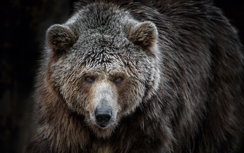

In [21]:
im = Image.open(dest)
im.to_thumb(244,244)

In [55]:
path = Path('bears')
bear_types = ['grizzly','black','teddy']

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f"{o} bear", 50)
        download_images(dest,urls=results)

In [3]:
path = Path('bears')
fns = get_image_files(path)
fns

(#110) [Path('bears/grizzly/30c1b399-510e-4ce3-88a7-0f544af8b5cf.jpg'),Path('bears/grizzly/9a1d19df-89a7-4309-bb68-9f8c94028c98.jpg'),Path('bears/grizzly/38009d45-8425-4bfe-b41b-51a32047eb71.jpg'),Path('bears/grizzly/c23b3c81-d33c-44c4-83e2-a4959d18b0c5.jpg'),Path('bears/grizzly/381ce39f-b8f7-4c94-a80e-c444736eb1c0.jpg'),Path('bears/grizzly/be1c9bf3-c44c-4539-8901-6f39c0507110.jpg'),Path('bears/grizzly/c4d64ecc-6763-4e46-aa0a-31931b2e58e3.jpg'),Path('bears/grizzly/856e3c08-af97-46a2-abb3-97be6936a1d8.jpg'),Path('bears/grizzly/9001c3c7-9063-4b7e-9f84-1ea994aacea8.jpg'),Path('bears/grizzly/e1b3e2c3-f984-482d-9059-27b11162df13.jpg')...]

In [4]:
failed = verify_images(fns)
len(failed)

0

In [5]:
failed.map(Path.unlink);

In [6]:
bears = DataBlock(blocks = [ImageBlock,CategoryBlock],
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2,seed=78),
                  get_y = parent_label,
                  item_tfms=Resize(128)
                 )

In [7]:
dls = bears.dataloaders(path)

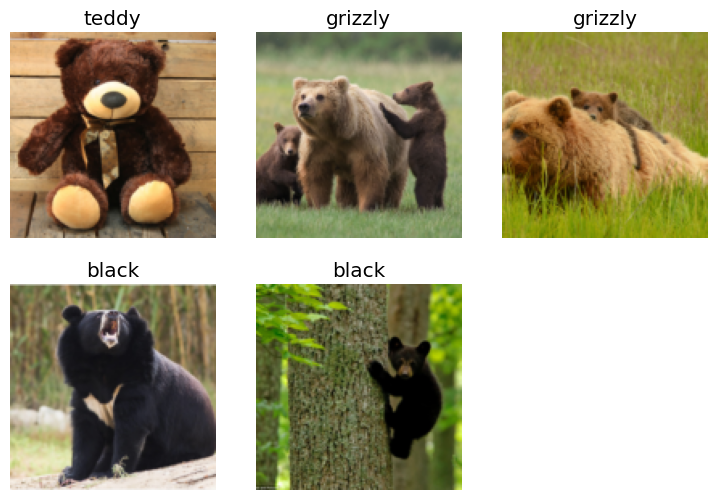

In [8]:
dls.valid.show_batch(max_n=5)

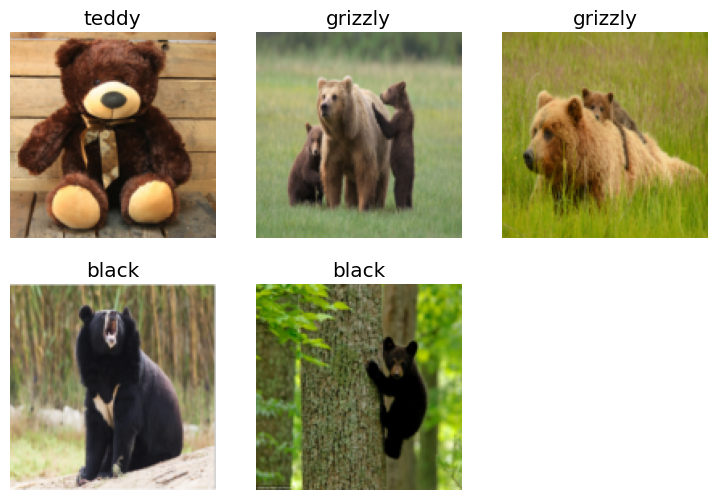

In [38]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=5)

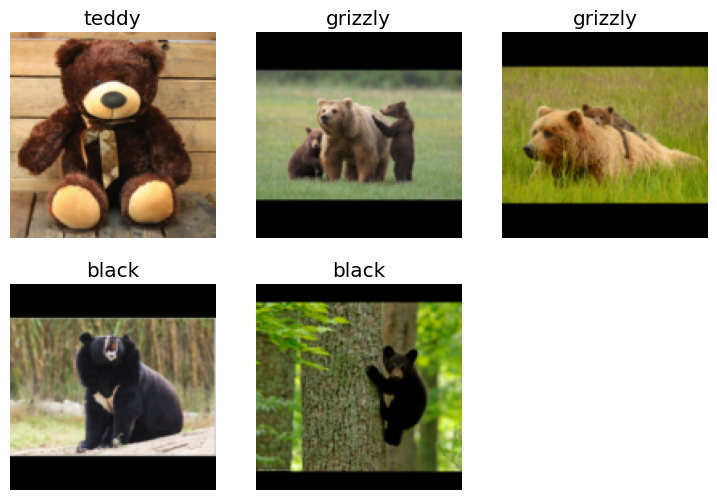

In [42]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=5)

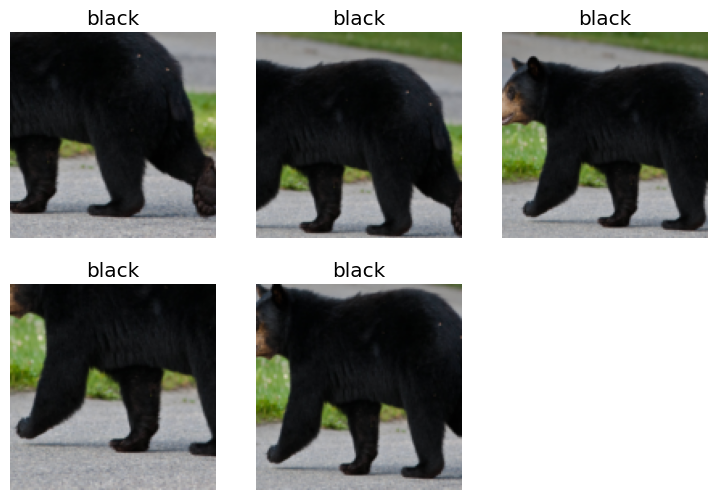

In [45]:
bears = bears.new(item_tfms=RandomResizedCrop(128,min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=5,unique = True)

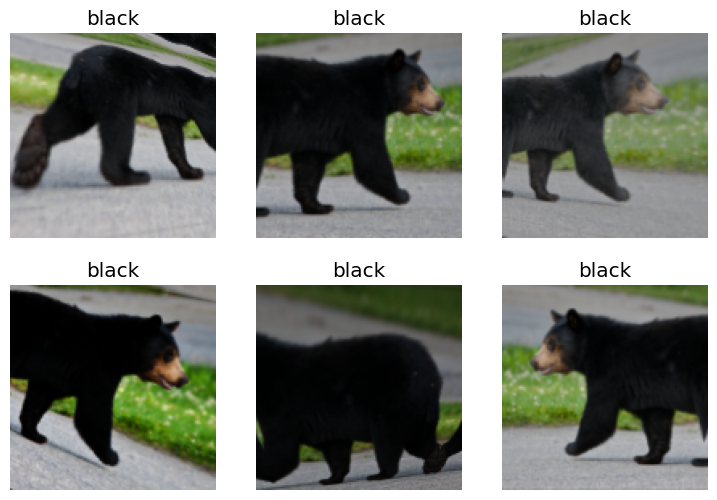

In [50]:
bears = bears.new(item_tfms=Resize(128),batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=6,unique = True)

In [9]:
bears = bears.new(item_tfms=RandomResizedCrop(224,min_scale=0.3)
                  ,batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [15]:
learner = vision_learner(dls,resnet18,metrics=error_rate)
learner.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.282849,3.467921,0.727273,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.823293,2.148461,0.545455,00:07
1,1.758782,1.058706,0.363636,00:06
2,1.478680,0.379511,0.227273,00:06
3,1.172331,0.178144,0.090909,00:06
4,0.983404,0.123745,0.045455,00:06
5,0.871257,0.109566,0.045455,00:07
6,0.760585,0.094440,0.045455,00:06
7,0.687632,0.089606,0.045455,00:06


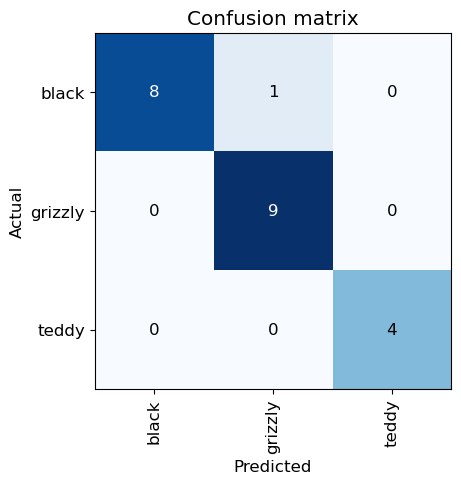

In [16]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

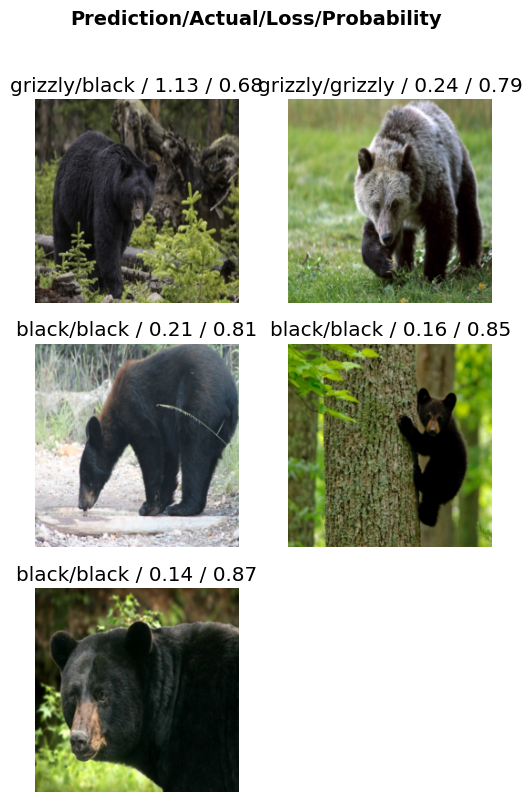

In [17]:
interp.plot_top_losses(5,nrows=3)

In [13]:
cleaner = ImageClassifierCleaner(learner)
cleaner

In [18]:
learner.export()

In [19]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [20]:
learn_inf = load_learner(path/'export.pkl')

In [21]:
learn_inf.predict(path/'grizzly.jpg')

('grizzly', tensor(1), tensor([1.9000e-03, 9.9809e-01, 1.3905e-05]))

In [22]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']